In [3]:
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt

In [89]:
dataset_path = Path('dataset')
images = dataset_path / 'image'
mask = dataset_path / 'masks'

df_measurements = []
for image_path in tqdm(list(images.iterdir())):
    mask_path = mask / (image_path.stem + '.png')
    assert mask_path.exists(), f"Mask not found for {mask_path}"
    assert image_path.suffix == '.jpg', f"Image {image_path} is not jpg"
    category_id = int(image_path.stem.split('_')[0])
    # Read mask and image
    mask_img = np.array(Image.open(mask_path))
    assert mask_img.shape == (512, 512), f"Mask {mask_path} is not 512x512"
    image = np.array(Image.open(image_path))
    assert image.shape == (512, 512, 3), f"Image {image_path} is not 512x512x3"
    
    # Check if image is all black (check if all values of image are equal)
    all_black = False
    if np.all(image == image[0, 0, :]):
        all_black = True

    percentage_mask  = (mask_img != 255).sum() / (512 * 512)
    df_measurements.append({
        'image_path': image_path,
        'mask_path': mask_path,
        'percentage_mask': percentage_mask,
        'nsfw': all_black,
        'category_id': category_id,
    })

df_measurements = pd.DataFrame(df_measurements)
df_measurements


  0%|          | 0/20011 [00:00<?, ?it/s]

,image_path,mask_path,percentage_mask,nsfw,category_id
0,dataset/image/20_141709_4136900885.jpg,dataset/masks/20_141709_4136900885.png,0.196156,False,20
1,dataset/image/12_46464_2326367169.jpg,dataset/masks/12_46464_2326367169.png,0.196293,False,12
2,dataset/image/3_701896_569157608.jpg,dataset/masks/3_701896_569157608.png,0.117470,False,3
3,dataset/image/15_730246_2113463438.jpg,dataset/masks/15_730246_2113463438.png,0.226448,False,15
4,dataset/image/9_804399_2731182248.jpg,dataset/masks/9_804399_2731182248.png,0.330757,False,9
...,...,...,...,...,...
20006,dataset/image/18_732407_1528361124.jpg,dataset/masks/18_732407_1528361124.png,0.284775,False,18
20007,dataset/image/12_822185_470598263.jpg,dataset/masks/12_822185_470598263.png,0.395744,False,12
20008,dataset/image/15_263841_2694409391.jpg,dataset/masks/15_263841_2694409391.png,0.568916,False,15
20009,dataset/image/19_397518_3632733192.jpg,dataset/masks/19_397518_3632733192.png,0.560898,False,19


In [90]:
# Compute percentiles 5% and 95% for each category of percentage_mask
df_g = df_measurements.groupby('category_id').agg({"percentage_mask": ["count", lambda x: np.percentile(x, 5), lambda x: np.percentile(x, 95)]}).reset_index()
# Remove multiindex
df_g.columns = df_g.columns.droplevel(1)
df_g.columns = ['category_id', "class_count", 'class_q5', 'class_q95']
df_g = df_measurements.merge(df_g, on='category_id')
df_g

,image_path,mask_path,percentage_mask,nsfw,category_id,class_count,class_q5,class_q95
0,dataset/image/20_141709_4136900885.jpg,dataset/masks/20_141709_4136900885.png,0.196156,False,20,690,0.085914,0.688655
1,dataset/image/20_666279_1098821323.jpg,dataset/masks/20_666279_1098821323.png,0.406742,False,20,690,0.085914,0.688655
2,dataset/image/20_616239_1112975191.jpg,dataset/masks/20_616239_1112975191.png,0.191341,False,20,690,0.085914,0.688655
3,dataset/image/20_638469_2675931782.jpg,dataset/masks/20_638469_2675931782.png,0.400345,False,20,690,0.085914,0.688655
4,dataset/image/20_621992_1362219992.jpg,dataset/masks/20_621992_1362219992.png,0.310017,False,20,690,0.085914,0.688655
...,...,...,...,...,...,...,...,...
20006,dataset/image/2_704896_3900373309.jpg,dataset/masks/2_704896_3900373309.png,0.347866,False,2,736,0.071667,0.496229
20007,dataset/image/2_228284_31995689.jpg,dataset/masks/2_228284_31995689.png,0.229984,False,2,736,0.071667,0.496229
20008,dataset/image/2_443963_1839871700.jpg,dataset/masks/2_443963_1839871700.png,0.232304,False,2,736,0.071667,0.496229
20009,dataset/image/2_254949_533744076.jpg,dataset/masks/2_254949_533744076.png,0.129021,False,2,736,0.071667,0.496229


In [93]:
# Load clip
import clip
import torch
from PIL import Image

device = "mps"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:25<00:00, 14.0MiB/s]


In [141]:
category_id_to_name = {
    0: "background",
    1: "aeroplane",
    2: "bicycle",
    3: "bird",
    4: "boat",
    5: "bottle",
    6: "bus",
    7: "car",
    8: "cat",
    9: "chair",
    10: "cow",
    11: "dining table",
    12: "dog",
    13: "horse",
    14: "motorbike",
    15: "person",
    16: "potted plant",
    17: "sheep",
    18: "sofa",
    19: "train",
    20: "tv monitor",
}

In [151]:
def rank_image(image_path, category_id):
    category_name = category_id_to_name[category_id]
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    text = clip.tokenize([f"a {category_name}", f"not a {category_name}"]).to(device)

    with torch.no_grad():
        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    return probs[0, 0]


In [ ]:
df_g['rank'] = -1.0
for i, row in (pbar := tqdm(list(df_g.iterrows()))):
    image_path = row['image_path']
    category_id = row['category_id']
    rank = rank_image(image_path, category_id)
    pbar.set_description(f"Ranking {row['image_path']} ({rank:.2f})")
    df_g.loc[i, 'rank'] = rank

In [188]:
# Compute 10% quantile by category of rank
df_grouped = df_g.groupby('category_id').agg({'rank': lambda x: np.percentile(x, 25)}).reset_index()
df_grouped.columns = ['category_id', 'rank_q25']
df_g2 = df_g.merge(df_grouped, on='category_id')
df_g2.to_csv("synthetic_dataset_with_rank.csv", index=False)
df_g2

,image_path,mask_path,percentage_mask,nsfw,category_id,class_count,class_q5,class_q95,rank,rank_q25
0,dataset/image/20_141709_4136900885.jpg,dataset/masks/20_141709_4136900885.png,0.196156,False,20,690,0.085914,0.688655,0.415039,0.458191
1,dataset/image/20_666279_1098821323.jpg,dataset/masks/20_666279_1098821323.png,0.406742,False,20,690,0.085914,0.688655,0.592773,0.458191
2,dataset/image/20_616239_1112975191.jpg,dataset/masks/20_616239_1112975191.png,0.191341,False,20,690,0.085914,0.688655,0.239380,0.458191
3,dataset/image/20_638469_2675931782.jpg,dataset/masks/20_638469_2675931782.png,0.400345,False,20,690,0.085914,0.688655,0.798340,0.458191
4,dataset/image/20_621992_1362219992.jpg,dataset/masks/20_621992_1362219992.png,0.310017,False,20,690,0.085914,0.688655,0.291016,0.458191
...,...,...,...,...,...,...,...,...,...,...
20006,dataset/image/2_704896_3900373309.jpg,dataset/masks/2_704896_3900373309.png,0.347866,False,2,736,0.071667,0.496229,0.395996,0.322510
20007,dataset/image/2_228284_31995689.jpg,dataset/masks/2_228284_31995689.png,0.229984,False,2,736,0.071667,0.496229,0.250977,0.322510
20008,dataset/image/2_443963_1839871700.jpg,dataset/masks/2_443963_1839871700.png,0.232304,False,2,736,0.071667,0.496229,0.803223,0.322510
20009,dataset/image/2_254949_533744076.jpg,dataset/masks/2_254949_533744076.png,0.129021,False,2,736,0.071667,0.496229,0.468750,0.322510


In [ ]:
a = df_g2.sort_values('rank', ascending=False).query("not nsfw and percentage_mask < class_q95 and percentage_mask > class_q5 and rank > rank_q25")

images_filtered = Path('images_filtered')
images_filtered.mkdir(exist_ok=True)
masks_filtered = Path('masks_filtered')
masks_filtered.mkdir(exist_ok=True)

import shutil

for i, row in (pbar := tqdm(list(a.iterrows()))):
    image_path = row['image_path']
    mask_path = row['mask_path']
    # Copy image to images_filtered
    image_path_filtered = images_filtered / image_path.name
    mask_path_filtered = masks_filtered / mask_path.name

    shutil.copy(image_path, image_path_filtered)
    shutil.copy(mask_path, mask_path_filtered)

a.to_csv("synthetic_dataset_filtered.csv", index=False)
    

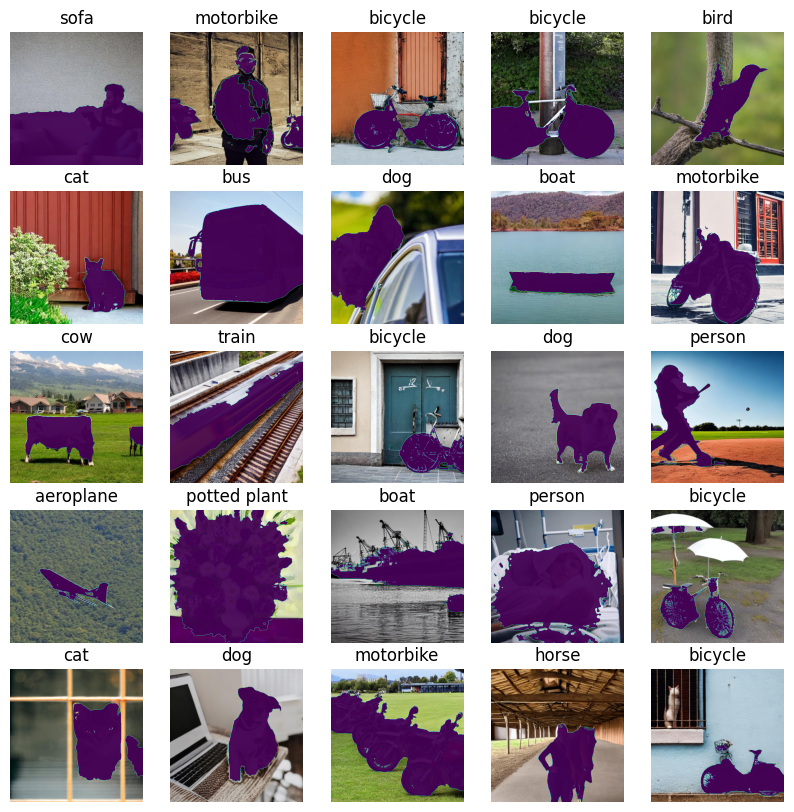

In [217]:
# Make an array of 10x10 images

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
# Make iterable of axes
axes = axes.flatten()
b = 3000
for i in range(25):
    ax = axes[i]

    mask = a.sort_values('rank', ascending=False).iloc[b+i].mask_path
    image = a.sort_values('rank', ascending=False).iloc[b+i].image_path

    mask = np.array(Image.open(mask))
    image = np.array(Image.open(image))
    classname = category_id_to_name[a.sort_values('rank', ascending=False).iloc[b+i].category_id]

    ax.set_title(classname)
    ax.imshow(image)
    ax.imshow(mask, alpha=1 - mask / 255)
    ax.axis('off')


In [31]:
df

,image_path,mask_path,percentage_mask,nsfw,category_id,class_count,class_q5,class_q95,rank,rank_q25,number
17877,dataset/image/1_103658_1322196805.jpg,dataset/masks/1_103658_1322196805.png,0.218525,False,1,838,0.039194,0.834171,0.985352,0.672363,0
19540,dataset/image/2_488020_3162576450.jpg,dataset/masks/2_488020_3162576450.png,0.181004,False,2,736,0.071667,0.496229,0.917480,0.322510,0
2535,dataset/image/3_41173_2566241124.jpg,dataset/masks/3_41173_2566241124.png,0.132034,False,3,960,0.031319,0.551537,0.887207,0.429199,0
17625,dataset/image/4_324251_719581613.jpg,dataset/masks/4_324251_719581613.png,0.114033,False,4,671,0.037449,0.731796,0.971680,0.509766,0
10458,dataset/image/5_687299_1123133455.jpg,dataset/masks/5_687299_1123133455.png,0.344761,False,5,894,0.198822,0.860454,0.970703,0.173218,0
...,...,...,...,...,...,...,...,...,...,...,...
5779,dataset/image/15_376976_3121140.jpg,dataset/masks/15_376976_3121140.png,0.420639,False,15,4153,0.079729,0.631094,0.025970,0.392334,4148
4334,dataset/image/15_822390_3260132852.jpg,dataset/masks/15_822390_3260132852.png,0.633854,False,15,4153,0.079729,0.631094,0.025970,0.392334,4149
3667,dataset/image/15_648268_16115522.jpg,dataset/masks/15_648268_16115522.png,0.463657,False,15,4153,0.079729,0.631094,0.024796,0.392334,4150
4483,dataset/image/15_718615_4205865567.jpg,dataset/masks/15_718615_4205865567.png,0.531857,False,15,4153,0.079729,0.631094,0.022629,0.392334,4151


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

df = pd.read_csv("synthetic_dataset_with_rank.csv").query("not nsfw").copy()
df = df.sort_values('rank', ascending=False)
df_prompts = pd.read_csv("synthetic_dataset_prompts.csv")

# Add number partitioned by category_id
df['number'] = df.groupby('category_id').cumcount()
df = df.sort_values(['number', 'category_id'])

#fig, axes = plt.subplots(10, 8, figsize=(50, 40))
#axes = iter(axes.flatten())
b = 50
for i, row in df[b:b+40].iterrows():
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
    fig, ax2 = plt.subplots(1, 1, figsize=(10, 10))   
    caption_id = int(row['image_path'].split("_")[1])
    caption_id = int(row['image_path'].split("_")[1])
    df_prompts_row = df_prompts.query(f"coco_caption_id == {caption_id}").iloc[0]
    print(row['image_path'], df_prompts_row.seed, df_prompts_row['prompt'])
    
    mask = np.array(Image.open(row['mask_path']))
    image = np.array(Image.open(row['image_path']))
    ax1.imshow(image)
    ax2.imshow(image)
    ax2.imshow(mask, alpha=1 - mask / 255)
    ax1.axis('off')
    ax1.set_title(row['image_path'].split("/")[-1], fontsize=8)
    ax2.axis('off')
df_prompts
